# Finding Lane Lines Notebook
The report can be found in README.md and a final script can be found in laneDetection.py

In [1]:
# Import packages
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Convert BGR images to RGB color space
def BGR2RGB(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def RGB2BGR(img):
    return cv.cvtColor(img, cv.COLOR_RGB2BGR)
    
# Function that displays images
def DisplayImage(img, name, C_MAP):
    plt.figure()
    if C_MAP == 'none':
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=C_MAP)
    plt.title(name)

### Helper Functions

In [3]:
def mid_point(line):
    for x1,y1,x2,y2 in line:
        midX = (x1 + x2) / 2
        midY = (y1 + y2) / 2
        return np.array([midX, midY])
    
def y_intercept(x,y,m):
    return y - (m*x)

def find_x(y,m,b):
    y = y - b
    return y / m

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    l_mid_points = np.array([0,0])
    l_slope = 0
    l_count = 0
    ly = img.shape[1]
    
    r_mid_points = np.array([0,0])
    r_slope = 0
    r_count = 0
    ry = img.shape[1]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Find the slope
            slope = (y2-y1)/(x2-x1)
            mid = mid_point(line)
            
            if math.isinf(slope):
                continue
                            
            # Group all lines into left and right
            if slope > 0:
                if round(slope) != 0:
                    r_mid_points = np.add(r_mid_points, mid)
                    r_slope = r_slope + slope
                    r_count = r_count + 1
                
                    ry = min(ry,y1,y2, round(img.shape[1]/2))
            elif round(slope) != 0:
                l_mid_points = np.add(l_mid_points, mid)
                l_slope = l_slope + slope
                l_count = l_count + 1
                
                ly = min(ly,y1,y2, round(img.shape[1]/2))
    
    # Calculate slope and position of lanes
    if l_count == 0 or r_count == 0:
        return
    
    l_slope = l_slope / l_count
    r_slope = r_slope / r_count
    
    l_mid = np.true_divide(l_mid_points, l_count)
    r_mid = np.true_divide(r_mid_points, r_count)
    
    # Find end points for the lanes
    bottomY = img.shape[1]
    
    l_intercept = y_intercept(l_mid[0], l_mid[1], l_slope)
    r_intercept = y_intercept(r_mid[0], r_mid[1], r_slope)
    
    l_top = round(find_x(ly, l_slope, l_intercept))
    l_bottom = round(find_x(bottomY, l_slope, l_intercept))
    
    r_top = round(find_x(ry, r_slope, r_intercept))
    r_bottom = round(find_x(bottomY, r_slope, r_intercept))
    
    # Draw final lane lines
    cv.line(img, (l_bottom, bottomY), (l_top, ly), [0,255,0], thickness*10)
    cv.line(img, (r_bottom, bottomY), (r_top, ry), [0,255,0], thickness*10)
    
    # Draw mid-point
    cv.circle(img, (round(l_mid[0]), round(l_mid[1])), 10, [0,0,255], thickness*5)
    cv.circle(img, (round(r_mid[0]), round(r_mid[1])), 10, [0,0,255], thickness*5)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv.addWeighted(initial_img, α, img, β, γ)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv.bitwise_and(img, mask)
    return masked_image

### Split Color Channels

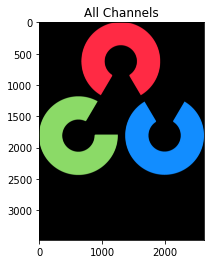

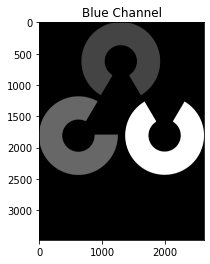

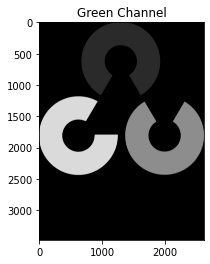

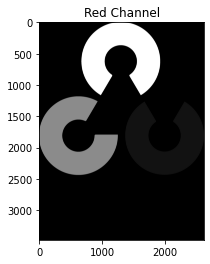

In [4]:
# Split an image into seperate BGR channels
def Split(img):
    b, g, r = cv.split(img)
    return b, g, r

# Merge channels into one image
def Merge(b, g, r):
    return cv.merge([b,g,r])

def RemoveChannel(img, channel):
    zeros = np.zeros([img.shape[0], img.shape[1]])
    img[:,:,channel] = zeros
    return img

# Test split function on test image
def TestSplit():
    openCV = cv.imread('test_images/OpenCV_Logo.png')
    b,g,r = Split(openCV)
    
    # Display original
    DisplayImage(BGR2RGB(openCV), 'All Channels', 'none')
    
    # Display blue channel
    DisplayImage(BGR2RGB(b), 'Blue Channel', 'none')
    
    # Display green channel
    DisplayImage(BGR2RGB(g), 'Green Channel', 'none')
    
    # Display red channel
    DisplayImage(BGR2RGB(r), 'Red Channel', 'none')
    
TestSplit()

With this we can decide what channel best shows lanes:

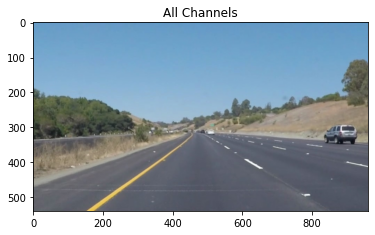

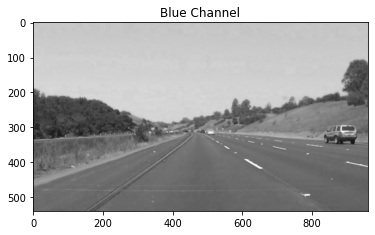

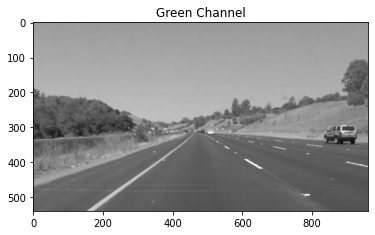

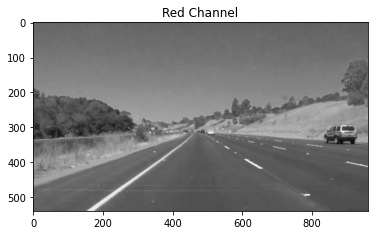

In [5]:
# Use split function on road image
testimg = cv.imread('test_images/solidYellowCurve.jpg')
b,g,r = Split(testimg)

# Display original
DisplayImage(BGR2RGB(testimg), 'All Channels', 'none')

# Display blue channel
DisplayImage(BGR2RGB(b), 'Blue Channel', 'none')

# Display green channel
DisplayImage(BGR2RGB(g), 'Green Channel', 'none')

# Display red channel
DisplayImage(BGR2RGB(r), 'Red Channel', 'none')

Clearly, the red channel shows lane markings the best

### Furthur Image Processing
Applying Gaussian Blur

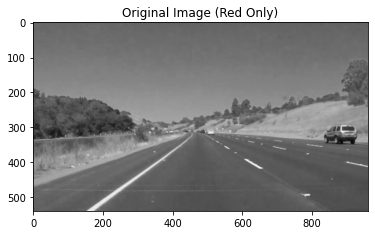

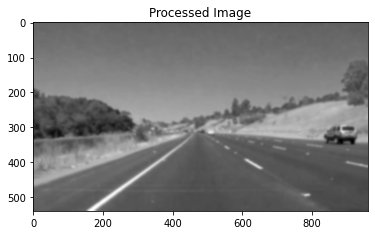

In [6]:
def GaussianBlur(img, kernel):
    return cv.GaussianBlur(img, (kernel, kernel), 0)

# Apply blur
blur = GaussianBlur(r, 15)

# Show the input
DisplayImage(BGR2RGB(r), 'Original Image (Red Only)', 'none')

# Show the output
DisplayImage(blur, 'Processed Image', 'gray')

### Canny Edge Detection

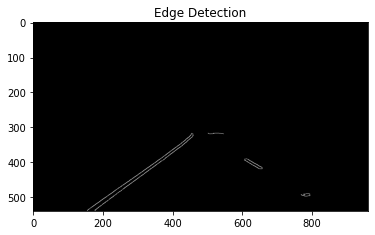

In [7]:
# Simple Canny Edge Detection Function
def Canny(img, minVal, maxVal):
    return cv.Canny(img, minVal, maxVal)

# Apply Canny Edge Detection to the processed image
edges = Canny(blur, 10, 150)

# Crop image to show just the road
shape = edges.shape
vertices = np.array([[(shape[1] - (shape[1]/2.3),shape[0]/1.7),(shape[1]/2.3,shape[0]/1.7),(0,shape[0]),(shape[1],shape[0])]],dtype=np.int32)
croppedEdges = region_of_interest(edges,vertices)

DisplayImage(croppedEdges, 'Edge Detection', 'gray')

### Applying Hough Lines

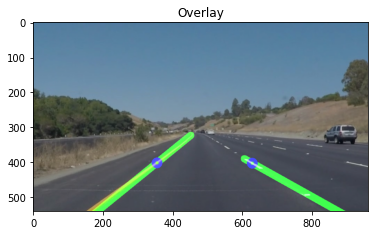

In [8]:
# Find hough lines in edges
lines = hough_lines(croppedEdges,2,np.pi/180,25,1,1.75)

# Overlay lines on initial image
overlay = weighted_img(lines, BGR2RGB(testimg))
DisplayImage(overlay, 'Overlay', 'none')

## Complete Lane Detection Function

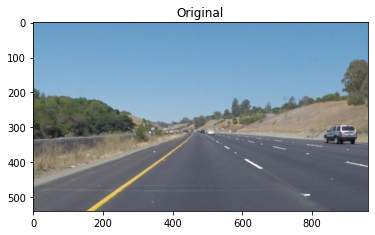

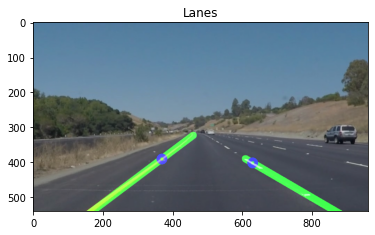

In [9]:
def FindLanes(img):
    # Split channels
    blue,green,red = Split(img)
    
    # Apply blur
    blurred = GaussianBlur(red, 15)
    
    # Apply Canny Edge Detection to the processed image
    cannyEdges = Canny(blurred, 10, 150)

    # Crop image to show just the road
    shape = cannyEdges.shape
    imgVertices = np.array([[(shape[1] - (shape[1]/2.3),shape[0]/1.8),(shape[1]/2.3,shape[0]/1.8),(0,shape[0]),(shape[1],shape[0])]],dtype=np.int32)
    regionEdges = region_of_interest(cannyEdges,imgVertices)
    
    # Find hough lines in edges
    houghLines = hough_lines(regionEdges,2,np.pi/180,25,1,1.75)

    # Overlay lines on initial image
    lanes = weighted_img(houghLines, BGR2RGB(img))
    return lanes

# Find lanes in a video by converting to BGR color space first
def FindLanesVid(frame):
    return FindLanes(RGB2BGR(frame))

DisplayImage(BGR2RGB(testimg), "Original", 'none')
DisplayImage(FindLanes(testimg), 'Lanes', 'none')

### Reading video files

In [10]:
# Read test video
testvidpath = "./test_videos/solidWhiteRight.mp4"
testoutput = './output/test.mp4'

testvid = VideoFileClip(testvidpath)
laneVid = testvid.fl_image(FindLanesVid)

laneVid.write_videofile(testoutput, audio=False)
HTML("""
    <video controls>
        <source src="""+testoutput+""" type="video/mp4"
    </video>
""")

Moviepy - Building video ./output/test.mp4.
MoviePy - Writing audio in testTEMP_MPY_wvf_snd.mp3
                                                        MoviePy - Done.
Moviepy - Writing video ./output/test.mp4



TypeError: must be real number, not NoneType

# Results

In [14]:
output = './output/yellowLeft.mp4'

vid = VideoFileClip("test_videos/solidYellowLeft.mp4")
laneVid = vid.fl_image(FindLanesVid)

laneVid.write_videofile(output, audio=False)
HTML("""
    <h2>Video 1</h2>
    <video controls>
        <source src="""+output+""" type="video/mp4"
    </video>
""")

t:   1%|▍                             | 9/681 [00:00<00:07, 85.11it/s, now=None]

Moviepy - Building video ./output/yellowLeft.mp4.
Moviepy - Writing video ./output/yellowLeft.mp4



Moviepy - Done !
Moviepy - video ready ./output/yellowLeft.mp4


In [ ]:
HTML("""
    <br>
    <h2>Video 2</h2>
    <video controls>
        <source src="""+testoutput+""" type="video/mp4"
    </video>
""")

In [12]:
output = './output/challenge.mp4'

vid = VideoFileClip("test_videos/challenge.mp4")
laneVid = vid.fl_image(FindLanesVid)

laneVid.write_videofile(output, audio=False)
HTML("""
    <video controls>
        <source src="""+output+""" type="video/mp4"
    </video>
""")

t:   2%|▍                             | 4/251 [00:00<00:07, 35.00it/s, now=None]

Moviepy - Building video ./output/challenge.mp4.
Moviepy - Writing video ./output/challenge.mp4



Moviepy - Done !
Moviepy - video ready ./output/challenge.mp4
